# Constant Acceleration and Noise

Generate 2d kinematic data with constant acceleration and noise. Adds noise to each measurement

In [155]:
using Plots
function generateKinematics(ax,ay,x0,y0,vx0,vy0,dt,measurements,noise,vnoise)
    #Measurement Arrays
    x = [x0]
    y = [y0]
    vx = [vx0]
    vy = [vy0]

    #Generate true gold set data based on kinematic equations 
    for i in 2:measurements
        xi = x[i-1] + vx[i-1] * dt + ax * .5 * dt^2
        yi = y[i-1] + vy[i-1] * dt + ay * .5 * dt^2
        vxi = vx[i-1] + ax*dt
        vyi = vy[i-1] + ay*dt
        append!(x,xi)
        append!(y,yi)
        append!(vx,vxi)
        append!(vy,vyi)
    end

    #Plot true data
    #plot(x,y, label="True")

    #Add and plot noise
    xn = x + (rand(Float64,size(x)) .* noise .- noise/2)
    yn = y + (rand(Float64,size(y)) .* noise .- noise/2)
    vxn = vx + (rand(Float64,size(vx)) .* vnoise .- vnoise/2)
    vyn = vy + (rand(Float64,size(vy)) .* vnoise .- vnoise/2)
    measurements = hcat(xn,yn,vxn,vyn)
    measurementsTrue = hcat(x,y,vx,vy)
    #scatter!(xn,yn,label="Measured")
    return measurements, measurementsTrue
end

noise = 30
vnoise = 2
dt = 1
measurements = 100
#ax,ay,x,y,vx,vy
m1,m1T = generateKinematics( .1 , .1  ,0.0   ,60.0  ,0.0, 0.0,dt,measurements,noise,vnoise)
m2,m2T = generateKinematics(-.1 , .1  ,400.0 ,400.0,0.0, 0.0,dt,measurements,noise,vnoise)
m3,m3T = generateKinematics( .05, .05 ,20.0  ,30.0 ,0.0, 0.0,dt,measurements,noise,vnoise)
m4,m4T = generateKinematics(  0 , .1  ,333   ,0.0  ,0.0, 0.0,dt,measurements,noise,vnoise)
measurementsNoise = permutedims(cat(m1,m2,m3,m4,dims=3),[2,3,1])
measurementsTrue = permutedims(cat(m1T,m2T,m3T,m4T,dims=3),[2,3,1])

4×4×100 Array{Float64,3}:
[:, :, 1] =
  0.0  400.0  20.0  333.0
 60.0  400.0  30.0    0.0
  0.0    0.0   0.0    0.0
  0.0    0.0   0.0    0.0

[:, :, 2] =
  0.05  399.95  20.025  333.0 
 60.05  400.05  30.025    0.05
  0.1    -0.1    0.05     0.0 
  0.1     0.1    0.05     0.1 

[:, :, 3] =
  0.2  399.8  20.1  333.0
 60.2  400.2  30.1    0.2
  0.2   -0.2   0.1    0.0
  0.2    0.2   0.1    0.2

...

[:, :, 98] =
 470.45  -70.45  255.225  333.0 
 530.45  870.45  265.225  470.45
   9.7    -9.7     4.85     0.0 
   9.7     9.7     4.85     9.7 

[:, :, 99] =
 480.2  -80.2  260.1  333.0
 540.2  880.2  270.1  480.2
   9.8   -9.8    4.9    0.0
   9.8    9.8    4.9    9.8

[:, :, 100] =
 490.05  -90.05  265.025  333.0 
 550.05  890.05  275.025  490.05
   9.9    -9.9     4.95     0.0 
   9.9     9.9     4.95     9.9 

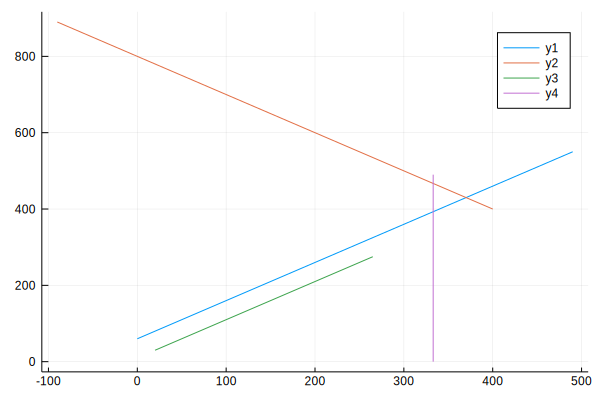

In [156]:
plot(measurementsTrue[1,1,:],measurementsTrue[2,1,:])
plot!(measurementsTrue[1,2,:],measurementsTrue[2,2,:])
plot!(measurementsTrue[1,3,:],measurementsTrue[2,3,:])
plot!(measurementsTrue[1,4,:],measurementsTrue[2,4,:])

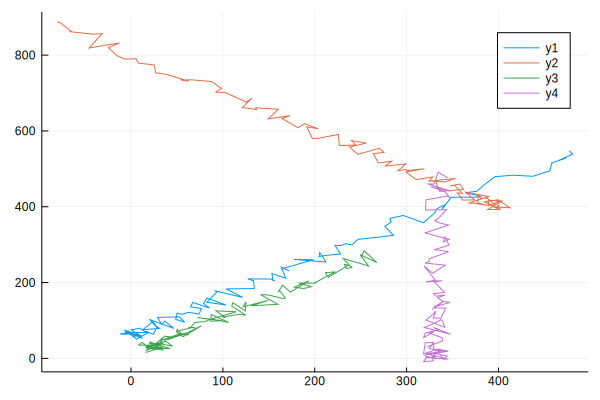

In [157]:
plot(measurementsNoise[1,1,:],measurementsNoise[2,1,:])
plot!(measurementsNoise[1,2,:],measurementsNoise[2,2,:])
plot!(measurementsNoise[1,3,:],measurementsNoise[2,3,:])
plot!(measurementsNoise[1,4,:],measurementsNoise[2,4,:])

In [158]:
file = open("data/measurements.hpp","w+")
write(file, "float measurements[100][4][4] = {")
write(file, replace(replace(replace(replace(string(measurementsNoise) , "[" => "{{"),"]"=>"}},")," "=>", "),";,"=>"} ,{")[1:end-1])  
write(file, "};\n")

close(file)

Kalman Filter Functions

In [159]:
using LinearAlgebra
function predict(A,X,B,U,P,Q)
    Xp = A*X + B.*U
    Pp = A *P*transpose(A) + Q
    return Xp,Pp
end

function update(P,H,R,Xp,Y)
    Ht = transpose(H)
    K= (P*Ht)/(H*P*Ht+R)
    Xk = Xp + K* (Y-H*Xp)
    Pk = (I - K*H)*P
    return Xk,Pk,K
end 

update (generic function with 1 method)

Runs the Kalman Filter on kinematic data. State transition models based off kinematic equations. 
Non diagonal Covariance terms not used for simplicity.

In [160]:
function runKalmanKinematic(measurements,dt,ax1,ay1,ax2,ay2,ax3,ay3,ax4,ay4,noise,vnoise)
    #Set up initial state
    X = measurements[:,:,1]
    xpred = [X]
    kalmanGains = []
    
    #State transisition matrix, adds dt*velocity to position
    A = [1 0 dt 0; 0 1 0 dt; 0 0 1 0; 0 0 0 1]
    
    #Control matrix, updates position and velocity based on acceleration
    B = [.5*dt^2;.5*dt^2;dt;dt] 
    U = [ax1 ax2 ax3 ax4;ay1 ay2 ay3 ay4;ax1 ax2 ax3 ax4;ay1 ay2 ay3 ay4]
    H = I
    R = [noise^2 0 0 0;
         0 noise^2 0 0;
         0 0 vnoise^2 0;
         0 0 0 vnoise^2]
    Q = I 
    P = Q
    for i in 2:(size(measurements)[3])
        Xp, Pp = predict(A,X,B,U,P,Q)
        Xk, Pk, K = update(Pp,H,R,Xp,measurements[:,:,i])
        append!(xpred,[Xk])
        append!(kalmanGains,[diag(K)])
        P = Pk
        X = Xk
    end
    return cat(xpred...,dims=3),hcat(kalmanGains...)
end

runKalmanKinematic (generic function with 1 method)

Kalman Filter is run on measurements, green line is filtered value and blue line is the true value

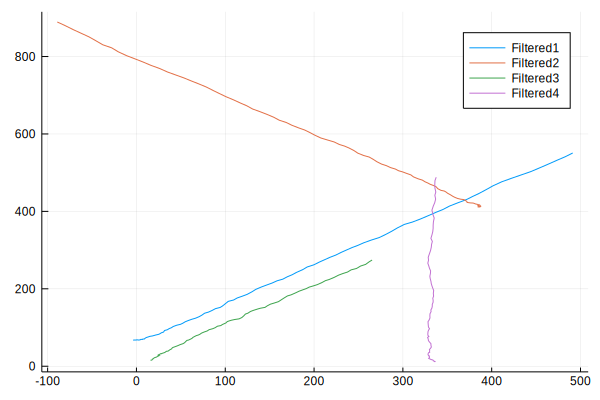

In [168]:
xf,kGains = runKalmanKinematic(measurementsNoise,dt,.1,.1,-.1,.1,.05,.05,0,.1,noise/2,vnoise/2)
plot(xf[1,1,:],xf[2,1,:],label="Filtered1")
plot!(xf[1,2,:],xf[2,2,:],label="Filtered2")
plot!(xf[1,3,:],xf[2,3,:],label="Filtered3")
plot!(xf[1,4,:],xf[2,4,:],label="Filtered4")

RMSE error of filtered values. X, Y, Vx, Vy in order

In [167]:
sqrt.(sum((xf - (measurementsTrue)).^2,dims=3)/100)

4×4×1 Array{Float64,3}:
[:, :, 1] =
 1.65667   5.19542   2.01469   2.87465 
 2.65046   4.43239   5.34087   5.22788 
 0.371336  0.385044  0.383868  0.428477
 0.361083  0.412014  0.392291  0.414065